```Python
!pip install torch torchvision
!pip3 install tqdm
```

In [1]:
import pickle
from pathlib import Path
from collections import namedtuple
from itertools import chain
from copy import deepcopy

from tqdm import notebook, tqdm
from typing import List, Generator

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.metrics import precision_recall_curve, average_precision_score, recall_score, precision_score

from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
import torch
from torch import nn
from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader

In [5]:
from utils import plot_confusion_matrix, evaluate_model, load_pickle

In [6]:
pd.set_option('max_colwidth', 800)
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 3.0})
sns.set_style("darkgrid", {"axes.facecolor": ".89"})

# torch.manual_seed(170188)
# np.random.seed(170188)


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
class PatienstDataset(Dataset):
    """Emerson Patients dataset."""

    N = 80

    def __init__(self, root_dir, word2idx):
        self.df = PatienstDataset.collect_data(root_dir)

        self.data, self.target = self.__extract_info(word2idx)
        self.padded = list(map(lambda x: np.pad(x, (0, PatienstDataset.N - len(x)), 'constant', constant_values=0), self.data))

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        sample = torch.LongTensor(self.padded[idx])
        target = torch.tensor(self.target[idx], dtype=torch.float32)

        return sample, target

    def __extract_info(self, word2idx):
        
        self.df['convert'] = self.df['amino_sequences'].apply(lambda x: PatienstDataset.despach(word2idx, x))
        self.df['target'] = self.df['target'].map({'positive': 1, 'negative': 0})

        return self.df['convert'].values, self.df['target'].values

    @staticmethod
    def despach(word2idx, x):
        return [word2idx[word] for word in x]

    @staticmethod
    def collect_data(path: Generator) -> object:

        patient_doent_include_sequences = []
        count = 0

        patients = []
        max_sequences = 0
        
        patient = namedtuple('patient', ['name', 'data', 'label'])
        
        for item in path.glob('*'):

            name, label = item.stem.split('_')

            try:

                df = pd.read_csv(item, usecols=['combined'])
                
#                 df.drop_duplicates(keep='first', inplace=True)
#                 df.reset_index(drop=True,inplace=True)
                
                max_sequences = df.shape[0] if df.shape[0] > max_sequences else max_sequences

                df = df['combined'].str.split('_', expand=True)

                df.rename(columns={0: 'v_gene', 1: 'amino_sequence', 2: 'j_gene'}, inplace=True)

                amino_acid = df['amino_sequence'].to_list()

                person = patient(name, amino_acid, label)
                
                patients.append(person)
                
            except KeyError:
                
                count += 1
                patient_doent_include_sequences.append(item.name)

        print(f"Maximum number of sequences is: {max_sequences}")
        print(f"The number of patients filtered due to centers is: {count}")
        print(f"Patient names/files is: {patient_doent_include_sequences}")

        names, train_text, labels = zip(*patients)
        data_frame = pd.DataFrame({'patient_name': names, 'amino_sequences': train_text, 'target': labels})

        return data_frame

In [9]:
ROOT = Path('data')
TRAIN = ROOT / 'lstm_train_256'
TEST = ROOT / 'lstm_test_256'

In [10]:
# Load golden TCRs
obj = load_pickle('256_centers.pkl')

In [11]:
# Provide an index for each sequence in the embedding layer
words = list(map(lambda x: x.split('_')[1], obj))
word2idx = {word: idx for idx, word in enumerate(sorted(words), 1)}
print(len(word2idx))

256


In [12]:
# Add padding to the sequence dictionary
word2idx['__Meaningless__'] = 0
word2idx = dict(sorted(word2idx.items(), key=lambda item: item[1]))
print(len(word2idx))


257


In [13]:
list(word2idx.items())[:5]

[('__Meaningless__', 0),
 ('CAISEAQNTEAFF', 1),
 ('CAISESGTGGGYTF', 2),
 ('CAISESQDRGHEQYF', 3),
 ('CASASANYGYTF', 4)]

In [14]:
train_dataset = PatienstDataset(TRAIN, word2idx)

train_dataloader = DataLoader(train_dataset, batch_size=50,shuffle=True)

Maximum number of sequences is: 77
The number of patients filtered due to centers is: 3
Patient names/files is: ['HIP13945_negative.csv', 'HIP13465_negative.csv', 'HIP05763_negative.csv']


In [15]:
len(train_dataset)

638

In [16]:
print(train_dataset.data[:2])

[list([26, 111, 171, 92, 201, 86, 135, 172, 182, 183, 28, 57, 8, 58, 61, 28, 87, 46, 84, 57, 174, 207, 39, 85, 52, 52, 8, 81, 45, 46, 45, 68, 46])
 list([117, 197, 120, 19, 93, 50, 209, 50, 12, 15, 78, 140, 50, 197, 237, 219, 2, 193, 245, 32, 85, 215, 153, 96, 219])]


In [17]:
test_dataset = PatienstDataset(TEST, word2idx)

test_dataloader = DataLoader(test_dataset, batch_size=1,shuffle=True)

Maximum number of sequences is: 63
The number of patients filtered due to centers is: 2
Patient names/files is: ['Keck0063_negative.csv', 'Keck0024_negative.csv']


In [18]:
class Net(nn.Module):
    def __init__(self, embeddings_shape=len(word2idx), embedding_dim=10, hidden_layer=10):
        super(Net,self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=embeddings_shape, embedding_dim=embedding_dim)
        
        self.fc1 = nn.Linear(embedding_dim,hidden_layer)
        self.fc2 = nn.Linear(hidden_layer,1)  
        
        self.bn1 = nn.BatchNorm1d(hidden_layer, affine=False)
        
        self.dropout = nn.Dropout(0.2)
    
    def forward(self,x):
        
        # (1) embeddings layer  
#         self.embedding_layer.weight.data[0, :] = 0
        x = self.embedding_layer(x)
        x = torch.sum(x, 1)
        
#         output = open('person_embedding.pkl', 'wb')
#         pickle.dump(x.detach().numpy(), output)
#         output.close()
        
        
        # (1) hidden layer
        x = self.dropout(x)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.bn1(x)
        
        # (2) output layer
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        
        return x

In [19]:
#hyper parameters
learning_rate = 0.05
Epochs = 25

In [20]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [21]:
model = Net(embeddings_shape=len(word2idx) , embedding_dim=7, hidden_layer=16)
model.apply(init_weights)
model

Net(
  (embedding_layer): Embedding(257, 7)
  (fc1): Linear(in_features=7, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [22]:
# Optimizer, Loss
optimizer = Adam([p for p in model.parameters() if p.requires_grad],lr=learning_rate, weight_decay=0.005)
loss_fn = nn.BCELoss()

In [23]:
losses = []
accur = []

best_accuracy = 0
best_loss = 9E6
l1_regularization, l2_regularization = torch.tensor(0.), torch.tensor(0.)

for epoch in range(Epochs):
    model = model.train()
    progress_bar = notebook.tqdm_notebook(train_dataloader, leave=False)
    for batch in progress_bar:
        
        x_train, y_train = batch
        
        #calculate output
        output = model(x_train)
         
        #calculate loss
        loss = loss_fn(output,y_train.reshape(-1,1))
        
        #backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        
    model = model.eval()
    with torch.no_grad():    

        #accuracy
        predicted = model(torch.tensor(train_dataset.padded,dtype=torch.int64))
        
        train_probs =  predicted.reshape(-1).detach().numpy()
        y_pred_train = predicted.reshape(-1).detach().numpy().round()
        
        y_true_train = train_dataset.target
        
        cur_accuracy = (predicted.reshape(-1).detach().numpy().round() == train_dataset.target).mean()
        
        #auc
        fpr, tpr, _ = roc_curve(y_true_train, train_probs)
        roc_auc = auc(fpr, tpr)
       
       
        
        
    cur_loss = loss.item()
    progress_bar.set_description(f"Loss: {loss.item():.3f}")
      
    if cur_accuracy >= best_accuracy and cur_loss < best_loss:
        print(f"Epoch #{epoch+1}, Saving .......{best_accuracy} ---> {cur_accuracy}......{best_loss} ---> {cur_loss}")
        
        best_accuracy = cur_accuracy 
        best_loss = cur_loss 
        
        output = open('sequence_embedding.pkl', 'wb')
        pickle.dump(model.embedding_layer.weight.detach().numpy(), output)
        output.close()
        
        
        print()
        best_model = deepcopy(model)

    if (epoch+1)%10 == 0:
                
        tqdm.write(f"\nEpoch #{epoch+1}: Train Loss: {loss:.5f} Train Accuracy: \
            {best_accuracy:.5f} Train AUC: {roc_auc:.5f}")
        
        tqdm.write(f"The average precision score of model is \
            {round(average_precision_score(y_true_train, train_probs),3)*100} %")
        
        
    losses.append(loss.item())
    accur.append(cur_accuracy)

torch.save(best_model.state_dict(), 'model.pt')


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch #1, Saving .......0 ---> 0.5815047021943573......9000000.0 ---> 0.6787745952606201



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch #2, Saving .......0.5815047021943573 ---> 0.6912225705329154......0.6787745952606201 ---> 0.6037831902503967



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch #3, Saving .......0.6912225705329154 ---> 0.822884012539185......0.6037831902503967 ---> 0.5150768160820007



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch #4, Saving .......0.822884012539185 ---> 0.8996865203761756......0.5150768160820007 ---> 0.48001551628112793



  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch #7, Saving .......0.8996865203761756 ---> 0.9200626959247649......0.48001551628112793 ---> 0.44357019662857056



  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]


Epoch #10: Train Loss: 0.30001 Train Accuracy:             0.92006 Train AUC: 0.99566
The average precision score of model is             99.5 %


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch #12, Saving .......0.9200626959247649 ---> 0.9655172413793104......0.44357019662857056 ---> 0.3347391188144684



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch #13, Saving .......0.9655172413793104 ---> 0.9655172413793104......0.3347391188144684 ---> 0.2770647406578064



  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch #15, Saving .......0.9655172413793104 ---> 0.9764890282131662......0.2770647406578064 ---> 0.20178355276584625



  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]


Epoch #20: Train Loss: 0.46023 Train Accuracy:             0.97649 Train AUC: 0.99879
The average precision score of model is             99.9 %


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch #23, Saving .......0.9764890282131662 ---> 0.9921630094043887......0.20178355276584625 ---> 0.12873563170433044



  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [24]:
from sklearn.manifold import TSNE
obj = load_pickle('person_embedding_train.pkl')

X_embedded = TSNE(n_components=2, verbose=True, n_iter=5000).fit_transform(obj)

df_subset = pd.DataFrame(X_embedded, columns=['tsne-2d-one', 'tsne-2d-two'])
df_subset['person_name'] = train_dataset.df['patient_name']

df_subset['target'] = train_dataset.df['target']
df_subset['target'] = df_subset['target'].map({1: 'positive', 0: 'negative'})


df_subset.head()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 638 samples in 0.001s...
[t-SNE] Computed neighbors for 638 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 638 / 638
[t-SNE] Mean sigma: 3.360651
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.367226
[t-SNE] KL divergence after 3950 iterations: 0.722020


,tsne-2d-one,tsne-2d-two,person_name,target
0,-4.941134,-61.833241,HIP14361,positive
1,-4.095852,-61.167004,HIP14041,positive
2,-4.163083,-63.314800,HIP14096,positive
3,9.471843,27.191271,HIP10389,negative
4,-3.210927,-69.483009,HIP14103,positive


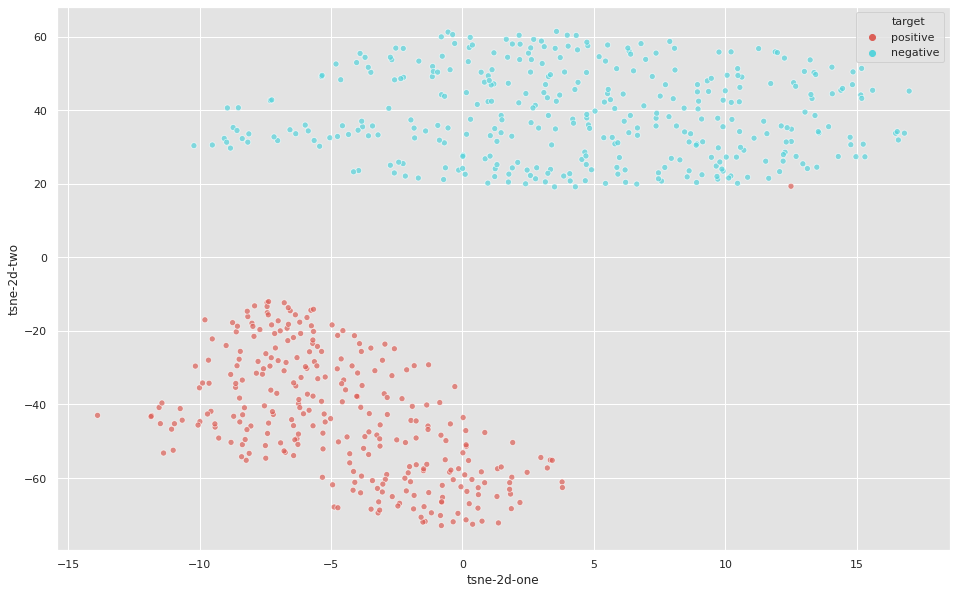

In [25]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    hue='target',
    legend="full",
    alpha=0.7
);


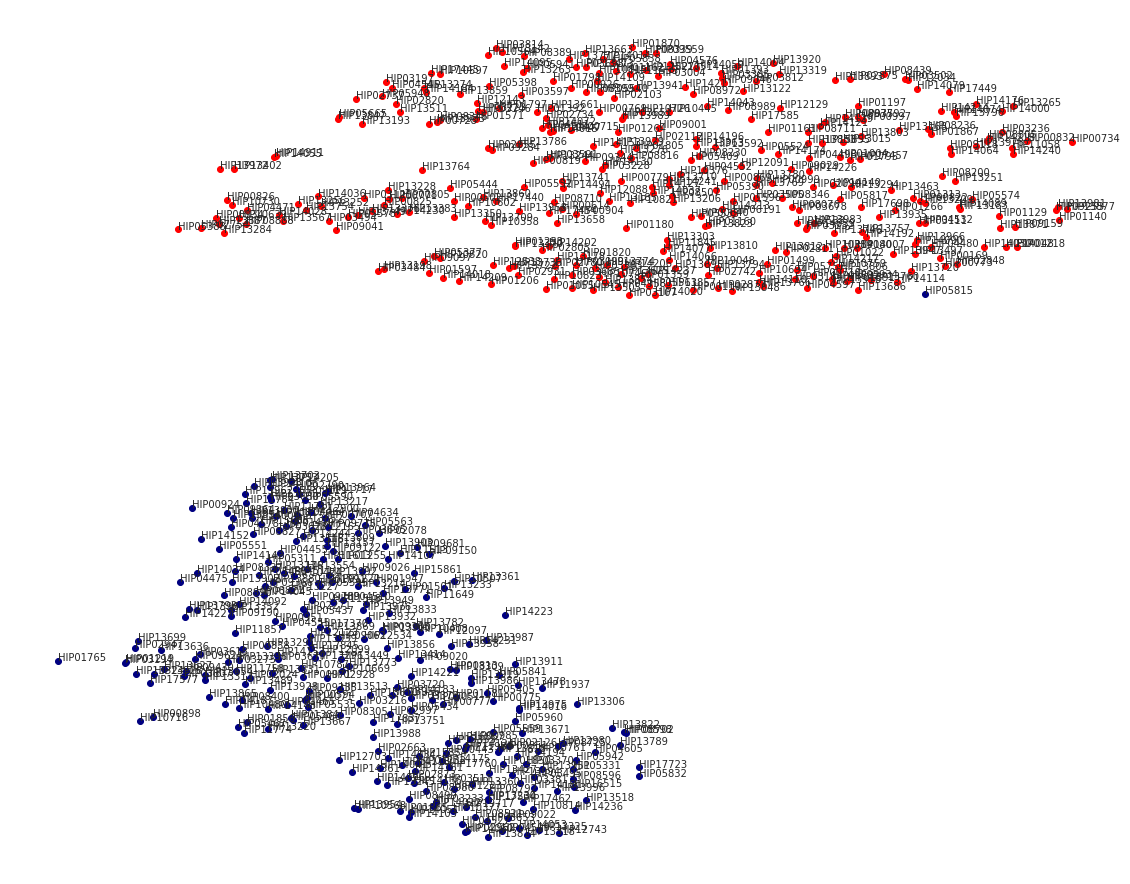

In [26]:
x, y = zip(*X_embedded)
names = df_subset['person_name'].to_list()
labels = df_subset['target'].to_list()

fig, ax = plt.subplots(figsize=(20, 16)) 

for i, (label, target) in enumerate(zip(names,labels)):

    if target == 'positive':
        color='navy'
    elif target == 'negative':
        color='red'
    
    ax.scatter(x[i], y[i], c=color)
    ax.annotate(label, (x[i], y[i]))
    
ax.axis('off')    
plt.show()

In [27]:
model = best_model.eval()
with torch.no_grad():
    #accuracy
    predicted = model(torch.tensor(train_dataset.padded,dtype=torch.int64))
        
        
    train_probs =  predicted.reshape(-1).detach().numpy()
    y_pred_train = train_probs.round()
    y_true_train = train_dataset.target
        
        
    acc = (y_pred_train == y_true_train).mean()    
        
    fpr, tpr, _ = roc_curve(y_true_train, train_probs)
    roc_auc = auc(fpr, tpr)
        

    average_precision = average_precision_score(y_true_train, train_probs)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
        
print(f'Train ROC AUC Score: {roc_auc}')
print(f"The Train Accuracy of the model is {round(accuracy_score(y_true_train,y_pred_train),3)*100} %")

print(
    f"Precision & Recall Report of model is,\n\n{classification_report(y_true_train, y_pred_train)}\n"
)


Average precision-recall score: 1.00
Train ROC AUC Score: 0.9992564023755465
The Train Accuracy of the model is 99.2 %
Precision & Recall Report of model is,

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       349
           1       0.99      0.99      0.99       289

    accuracy                           0.99       638
   macro avg       0.99      0.99      0.99       638
weighted avg       0.99      0.99      0.99       638




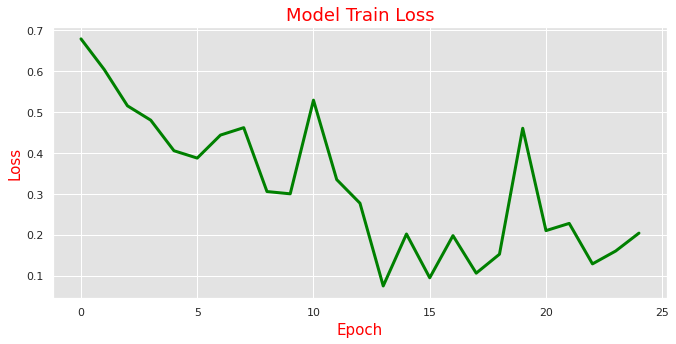

In [28]:
#plotting the loss
plt.figure(figsize=(11, 5))


plt.plot(losses, c='green')

plt.title('Model Train Loss', size=18, color='red')
plt.ylabel('Loss', color='red', size=15)
plt.xlabel('Epoch', color='red', size=15)
plt.xticks(list(range(0,Epochs+1,5)))

plt.show()

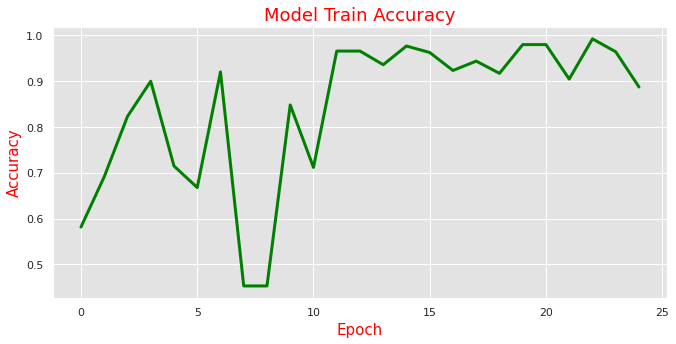

In [29]:
#printing the accuracy
plt.figure(figsize=(11, 5))


plt.plot(accur, c='green')

plt.title('Model Train Accuracy', size=18, color='red')
plt.ylabel('Accuracy', color='red', size=15)
plt.xlabel('Epoch', color='red', size=15)
plt.xticks(list(range(0,Epochs + 1,5)))
plt.show()

In [30]:
model = Net(embeddings_shape=len(word2idx) , embedding_dim=7, hidden_layer=16)
model.load_state_dict(torch.load('model_best.pt'))

<All keys matched successfully>

In [31]:
model = model.eval()
with torch.no_grad():
    #accuracy
    predicted = model(torch.tensor(test_dataset.padded,dtype=torch.int64))
        
        
    test_probs =  predicted.reshape(-1).detach().numpy()
  
    
    y_pred_test = test_probs.round()
    y_true_test = test_dataset.target
    
    acc = (y_pred_test == y_true_test).mean()    
        
    fpr, tpr, _ = roc_curve(y_true_test, test_probs)
    roc_auc = auc(fpr, tpr)
    
    
    average_precision = average_precision_score(y_true_test, test_probs)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
        
print(f'Test ROC AUC Score: {roc_auc}')
print(f"The Accuracy of the model is {round(accuracy_score(y_true_test,y_pred_test),3)*100} %")

print(
    f"Precision & Recall Report of model is,\n\n{classification_report(y_true_test, y_pred_test)}\n"
)


Average precision-recall score: 0.90
Test ROC AUC Score: 0.9350307287093942
The Accuracy of the model is 84.7 %
Precision & Recall Report of model is,

              precision    recall  f1-score   support

           0       0.90      0.82      0.86        67
           1       0.79      0.88      0.83        51

    accuracy                           0.85       118
   macro avg       0.85      0.85      0.85       118
weighted avg       0.85      0.85      0.85       118




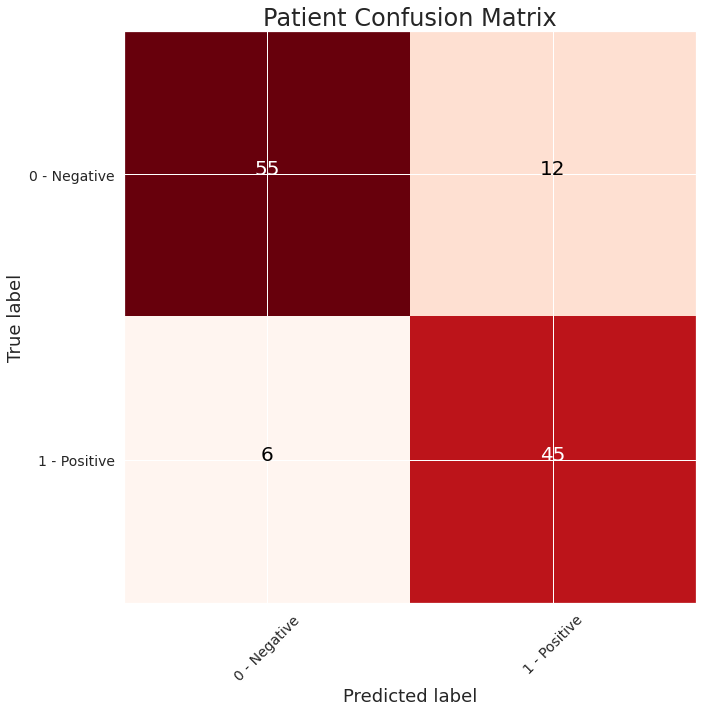

In [32]:
# Let's plot it out
cm = confusion_matrix(y_true_test, y_pred_test)
plot_confusion_matrix(cm, classes = ['0 - Negative', '1 - Positive'],
                      title = 'Patient Confusion Matrix', cmap=plt.cm.Reds)

Recall Baseline: 1.0 Test: 0.88 Train: 0.99
Precision Baseline: 0.43 Test: 0.79 Train: 0.99
Roc Baseline: 0.5 Test: 0.94 Train: 1.0


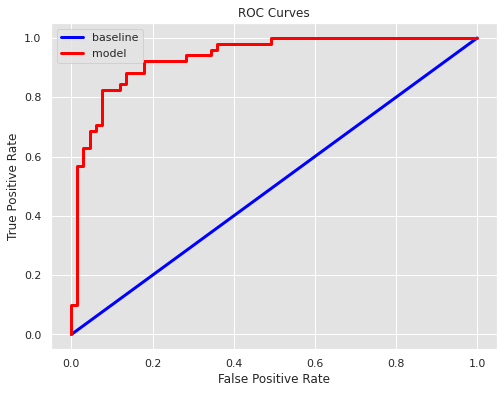

In [33]:
evaluate_model(y_test=y_true_test,
               y_pred=y_pred_test,
               probs=test_probs,
               y_train = y_true_train,
               train_predictions=y_pred_train,
               train_probs=train_probs)